## Thoughts
### Simplify the network
- Number of people on the airplane
- If a node has two egdes to the same node, we can merge them into one
- Cut off dead ends (Airports with no return)
- Merge airports that go from the same City. Example: JFK and NLI Airport
- Should airports have a certain amount of flights between airports before they are relevant?
- How many people does the average plane seat? Should we assume that planes with a shorter flight have fewer passengers and planes with a longer flight have more passengers.
- How often does a plane fly?

### How should the disease spread
- The number of airplanes leaving the airport should be equal to number of iterations for the specific airport.
- Probability for an infected person to travel with an airplane
- How much does the disease spread? For example, about 1/10 people in contact with the infected person gets the disease.




## Brief network description

We are working with an openflights airport network from icon.colorado.edu. which is a weighted, directed, multigraph, network where the nodes represent airports worldwide and the direction of edge {i,j} indicates a regularly occurring commercial flight, by a particular airline from airport i to airport j. Multiple edges may exist between pairs of airports if multiple airlines offer that flight, or if one airline offers multiple such flights each day. The  number of nodes is: 3214 and the  number of edges is: 18859.
https://networks.skewed.de/net/openflights


In [47]:
!pip install networkx
!pip install powerlaw
!pip install python-louvain
!pip install python-igraph
!pip install mpl_toolkits
!pip install shapely

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
ERROR: Could not find a version that satisfies the requirement mpl_toolkits (from versions: none)
ERROR: No matching distribution found for mpl_toolkits
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 1.1 MB 31.4 MB/s 
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


## Imports and Reading in our data

In [48]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import collections
from collections import Counter
import powerlaw # Power laws are probability distributions with the form:p(x)∝x−α
import numpy as np
#from mpl_toolkits.basemap import Basemap wont work ?
import matplotlib.pyplot as plt
import networkx as nx
import mpl_toolkits

import folium
from shapely.geometry import Point, MultiPoint, LineString, MultiLineString, Polygon, MultiPolygon
from folium.plugins import HeatMap, MarkerCluster
from folium import plugins

In [3]:
nodes = '../network/nodes.csv'
edges = "../network/edges.csv"

pd_nodes = pd.read_csv(nodes, sep=",")
pd_edges = pd.read_csv(edges, sep=",")
pd_edges.columns 

Index(['# source', ' target', ' distance', ' airline', ' airline_code',
       ' codeshare', ' equipment', ' stops'],
      dtype='object')

In [4]:
G =nx.from_pandas_edgelist(pd_edges,source='# source', target=' target', create_using = nx.MultiDiGraph)
print(nx.info(G))
#DiGraph = Directed graph without parallel edges and self loops
#MultiDiGraph = Directed graph with parallel edges and self loops

MultiDiGraph with 3214 nodes and 66771 edges


## Basic Network statistics - Exploratory data analysis
- Is it one fully connected component?
- Isolated nodes
- Is there any cycles?
- Is there any self loops? 
- Degree distribution plot and the cumulative distribution plot
- Does it follow the power law
- Calculate the density
- Global clustestering coefficient and average clustering coefficient
- Diameter and average diameter
- Path length distribution 
- Closeness and betweenness 
- Reach centrality 

### Connected Components

In [5]:
#connected components
# - Strong connectivity = When there is a path from every node to every other node --> taking into account directions (subgraph)
# - Weak connectivity = When there is a path from every node to every other node not taking into account the directions
print(nx.number_strongly_connected_components(G))
print(nx.number_weakly_connected_components(G))
#for i in nx.weakly_connected_components(G):
#    print(i)
#for i in nx.strongly_connected_components(G):
#    print(i)

48
7


### Isolated nodes

In [6]:
## Find isolated nodes:
for i in nx.isolates(G):
    print(i)
# There are not isolated nodes
print("There are no isolated nodes")

There are no isolated nodes


### Cycles

In [7]:
# Find Cycles
#https://groups.google.com/g/networkx-discuss/c/6FiQy-cxsBM for some insight into why this might not be possible
D = nx.DiGraph([(0, 1), (2, 0), (1, 2),(2,1)])
cycle= nx.simple_cycles(G)
#cycle = pd.DataFrame(list(cycle))
#print(cycle)
#cycle.to_csv("../network/cycles.csv", sep='\t',index=False)
##for i in cycle:
#   print(i)


In [8]:
#the code works but creates a document over 5gb (which deepnote refuses to store) so its a bit unreasonable to calculate i think
#with open("../network/cycles.csv", "w") as filename:
#  for i in cycle:
#    filename.write(f'{i}\n')

### Self loops

In [9]:
#Find self loops
nx.number_of_selfloops(G)
for i in nx.selfloop_edges(G):
    print("There is one self loop which can be found at node:", i)

There is one self loop which can be found at node: (1931, 1931)


In [10]:
#the source and target reference the index of the pd_nodes df
pd_edges[pd_edges["# source"]==1931]
#& pd_edges[" target"]==1931]]
#pd_nodes[pd_nodes["# index"]==1931]

,# source,target,distance,airline,airline_code,codeshare,equipment,stops
57358,1931,1930,352.862275,IL,10121,0,AT7,0
57359,1931,1589,673.949617,IL,10121,0,737,0
57360,1931,1590,214.215655,IL,10121,0,AT7 737,0
57361,1931,1931,0.000000,IL,10121,0,AT7,0
57362,1931,1942,544.646348,IL,10121,0,AT7,0
57363,1931,1925,495.988136,IL,10121,0,737 AT7,0
57364,1931,1941,534.399882,IL,10121,0,737,0


### Degree Distribution &amp; Cumulative Distribution Plots

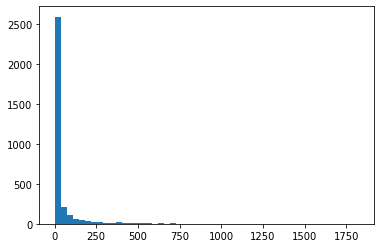

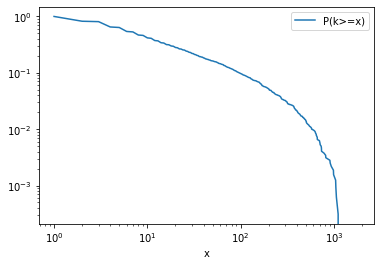

In [11]:
# Degree distribution plot
def plot_degree_dist(G):
    degrees = [(G.degree(n)) for n in G.nodes()]#np.log?
    plt.hist(degrees, 50)
    plt.show()

# The cumulative distribution plot (The y-axis in a CCDF is the probability of finding a node of degree k or high)
def plot_cum_dist(G):
    degrees = [G.degree(n) for n in G.nodes()]
    num_of_nodes = len(degrees)
    count_degrees = Counter([G.degree(n) for n in G.nodes()])
    count_degrees = collections.OrderedDict(sorted(count_degrees.items()))
    cum_dict = {}
    node_count = 0
    for degree, times in count_degrees.items():
        node_count += times
        cum_dict[degree]= 1 - (node_count/num_of_nodes)
    data = pd.DataFrame(list(cum_dict.items()),columns = ['x','P(k>=x)'])
    data.plot(x = 'x',y = 'P(k>=x)', loglog = True)
    plt.show()

def from_book(G):
    dd = Counter(dict(G.degree).values())
    dd = pd.DataFrame(list(dd.items()), columns = ("k", "count")).sort_values(by = "k")
    ccdf = dd.sort_values(by = "k", ascending = False)
    ccdf["cumsum"] = ccdf["count"].cumsum()
    ccdf["ccdf"] = ccdf["cumsum"] / ccdf["count"].sum()
    ccdf = ccdf[["k", "ccdf"]].sort_values(by = "k")
    dd.plot(kind = "scatter", x = "k", y = "count", color = "#e41a1c")
    plt.show()
plot_degree_dist(G)
plot_cum_dist(G)

### Density

In [12]:
#Density of the graph (Using networkx)
dens = nx.density(G)
print('Networkx density:', str(round(dens*100, 3))+'%')


#Density using the formular (simple directed graph)
# total egdes / total nodes*(total nodes - 1)
dens_form = (G.number_of_edges())/(G.number_of_nodes()*(G.number_of_nodes()-1))
print('Formular density:', str(round(dens_form*100, 3))+'%')


Networkx density: 0.647%
Formular density: 0.647%


### Global, local, average Clustering Coeffecients

In [13]:
#Global clustestering coefficient
#here we are assuming that connection is all that matters, therefore digraph is used not multidigraph 
G_di = nx.DiGraph(G)
global_clustering = nx.transitivity(G_di)
global_clustering
# Local clustering
local_clustering = nx.clustering(G_di)
#Average clustering coefficient
avg_clustering = nx.average_clustering(G_di)

print("Global clustering:", global_clustering)
print("Average clustering:",avg_clustering)
print("Local clustering:",local_clustering)

Global clustering: 0.25005448521436646
Average clustering: 0.4782853255477227
Local clustering: {0: 1.0, 2: 0.390625, 3: 0.3888888888888889, 1: 0.5714285714285714, 4: 0.12298387096774194, 5: 0.8333333333333334, 2250: 0.7, 2256: 1.0, 2251: 1.0, 2254: 0.8333333333333334, 2253: 1.0, 2243: 0.6666666666666666, 2246: 1.0, 2245: 0.6666666666666666, 2255: 0.42857142857142855, 1610: 0.1276029434789416, 2244: 0.3333333333333333, 2247: 0.6666666666666666, 2241: 0.5, 2135: 0.15270935960591134, 2242: 0, 1612: 0.16646848989298454, 1951: 0.2537746806039489, 2048: 0.08319738988580751, 1485: 0.20884986225895316, 2248: 1.0, 2249: 0, 1115: 0.1575091575091575, 903: 0.20793950850661624, 1058: 0.23894731832675012, 1607: 0.17473118279569894, 1639: 0.1134456794550018, 2257: 0, 6: 0.3, 7: 0.17857142857142858, 2260: 1.0, 2261: 0.3333333333333333, 2264: 1.0, 8: 0.2857142857142857, 1988: 0.2, 2266: 0.6666666666666666, 2262: 1.0, 13: 0.4926644581164221, 14: 0, 295: 0.2964827610152425, 1989: 0.6666666666666666, 9: 

### Diameter and average path length

In [14]:
setup=False
if setup==True:
    diameters=[]
    for i in (G.subgraph(c) for c in nx.strongly_connected_components(G)):
        diameters.append(nx.diameter(i))
    np.savetxt("../network/diameters.txt", diameters, delimiter="\n", fmt="%s")
else:
    diameters=np.genfromtxt("../network/diameters.txt",dtype=int,delimiter="\n")

print (diameters)

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 13  0  0  3  0
  0  0  0  3  2  0  1  1  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


In [15]:
#Path length distribution 
shortest = dict(nx.all_pairs_shortest_path_length(G))
#print(shortest)

In [16]:
all_paths_len = []
for i in shortest.values():
    for x in i.values():
        all_paths_len.append(x)

In [17]:
import statistics
print("Diameter: ",max(all_paths_len))
print("Av path length:",statistics.mean(all_paths_len))

Diameter:  13
Av path length: 3.984675772976349


### Log frequencies of path length

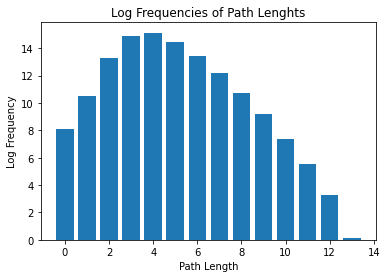

Counter({4: 3743759, 3: 2858173, 5: 1845025, 6: 680539, 2: 609545, 7: 197321, 8: 47043, 1: 36906, 9: 9886, 0: 3214, 10: 1576, 11: 248, 12: 27, 13: 1})


In [18]:
import math
count = Counter(all_paths_len)
plt.bar(count.keys(),[math.log(i+0.1) for i in count.values()])
plt.title("Log Frequencies of Path Lenghts")
plt.xlabel("Path Length")
plt.ylabel("Log Frequency")
plt.show()
print(count)


### Centrality

In [19]:
# Closeness
nx.closeness_centrality(G)

{0: 0.224592339092669,
 2: 0.22467311027122494,
 3: 0.22467311027122494,
 1: 0.22464079482925858,
 4: 0.2907325253258415,
 5: 0.224592339092669,
 2250: 0.2246084886820192,
 2256: 0.2245761918254972,
 2251: 0.2245761918254972,
 2254: 0.2245761918254972,
 2253: 0.22456004688000292,
 2243: 0.2245761918254972,
 2246: 0.2245761918254972,
 2245: 0.224592339092669,
 2255: 0.22612062053719706,
 1610: 0.32970553642609673,
 2244: 0.224592339092669,
 2247: 0.2245761918254972,
 2241: 0.224592339092669,
 2135: 0.28752119404462817,
 2242: 0.22454390425568546,
 1612: 0.28818435760686784,
 1951: 0.30095676385979775,
 2048: 0.24955103076622517,
 1485: 0.3741322616002923,
 2248: 0.2245761918254972,
 2249: 0.22454390425568546,
 1115: 0.3341853270675982,
 903: 0.3035597912634442,
 1058: 0.3774323649227695,
 1607: 0.354796711960568,
 1639: 0.3389355742296919,
 2257: 0.22454390425568546,
 6: 0.21171412851435817,
 7: 0.24445376835974647,
 2260: 0.1959617473087102,
 2261: 0.1743486409969212,
 2264: 0.17432918

In [21]:
#betweenness centrality
#nx.betweenness_centrality(G)

In [22]:
#global reaching centality
nx.global_reaching_centrality(G)

0.015025811825577145

### Community discovery

{0: 0, 2: 0, 3: 0, 1: 0, 4: 0, 5: 0, 2250: 0, 2256: 0, 2251: 0, 2254: 0, 2253: 0, 2243: 0, 2246: 0, 2245: 0, 2255: 0, 1610: 0, 2244: 0, 2247: 0, 2241: 0, 2135: 0, 2242: 0, 1612: 0, 1951: 0, 2048: 0, 1485: 1, 2248: 0, 2249: 0, 1115: 0, 903: 0, 1058: 1, 1607: 0, 1639: 0, 2257: 0, 6: 2, 7: 2, 2260: 2, 2261: 2, 2264: 2, 8: 2, 1988: 2, 2266: 2, 2262: 2, 13: 3, 14: 2, 295: 3, 1989: 2, 9: 2, 2265: 2, 10: 2, 11: 2, 12: 2, 218: 3, 308: 3, 315: 3, 282: 3, 368: 3, 294: 3, 1699: 4, 184: 3, 628: 17, 1853: 4, 1721: 4, 191: 3, 270: 3, 1829: 4, 1870: 4, 253: 3, 255: 4, 242: 3, 196: 3, 1754: 4, 2115: 4, 31: 4, 125: 4, 758: 3, 245: 3, 640: 3, 271: 3, 247: 3, 566: 3, 188: 3, 15: 4, 73: 4, 80: 4, 87: 4, 16: 4, 2288: 4, 121: 4, 122: 4, 17: 4, 89: 4, 124: 4, 65: 4, 99: 4, 18: 4, 46: 4, 130: 4, 19: 7, 2289: 7, 2326: 7, 79: 7, 90: 7, 20: 4, 71: 4, 97: 4, 3044: 4, 21: 4, 113: 4, 22: 7, 26: 7, 118: 7, 126: 7, 44: 7, 23: 4, 24: 4, 25: 4, 48: 4, 43: 7, 27: 7, 34: 7, 49: 7, 28: 7, 84: 7, 29: 4, 30: 4, 115: 4, 111:

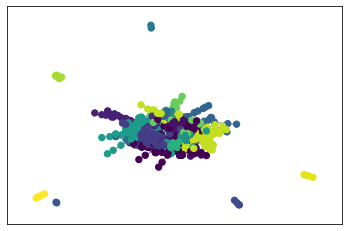

In [23]:
from community import community_louvain
import matplotlib.cm as cm

#make the graph undirected
undirected_G = G.to_undirected()
#Find the best partitioning
partition = community_louvain.best_partition(undirected_G)
print(partition)

#Draw the graph
pos = nx.spring_layout(undirected_G)
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40,
                    cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(undirected_G, pos, alpha=0.5)
plt.show()

### Power law

Calculating best minimal value for power law fit
-5.562512674077134 0.029117724710571603


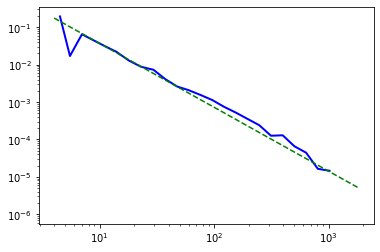

In [24]:
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
fit = powerlaw.Fit(degree_sequence)
fig2 = fit.plot_pdf(color='b', linewidth=2)
fit.power_law.plot_pdf(color='g', linestyle='--', ax=fig2)
R, p = fit.distribution_compare('power_law', 'lognormal')
print (R, p)

## Other Stuff

In [25]:
#plane types explored 
from collections import Counter
equipment=[]
for i in pd_edges[" equipment"]:
    possible=str(i).split()
    for j in possible:
        equipment.append(j)
unique_equipment_count=Counter(equipment)
unique_equipment=pd.DataFrame(set(equipment))
print("Amount of each plane type",unique_equipment_count)
print("Unique plane types",set(equipment))
#print(Counter(pd_edges[" equipment"])) nope


Amount of each plane type Counter({'320': 15400, '738': 10344, '319': 7847, '321': 3662, '73H': 3343, '737': 2753, '73W': 2492, 'CRJ': 2224, 'E90': 1968, 'AT7': 1595, '333': 1585, '73G': 1584, '332': 1439, 'DH4': 1387, '733': 1283, '763': 1183, 'CR7': 1161, '757': 1069, 'CR9': 1011, 'ER4': 989, 'ERJ': 947, '777': 945, '77W': 908, '330': 903, '739': 868, 'E70': 864, 'DH8': 785, 'M88': 725, '735': 705, 'E75': 701, 'M80': 656, '772': 633, 'ATR': 626, '73C': 623, '717': 614, '752': 604, '744': 599, '100': 590, '343': 490, 'DH3': 484, 'SF3': 475, '767': 461, '734': 460, 'CR2': 458, 'E95': 457, 'M90': 416, 'ERD': 415, '32S': 383, '773': 370, '736': 364, 'M83': 361, 'DHT': 354, '32A': 315, '75W': 311, 'DH1': 305, 'BEH': 290, '788': 287, 'AT4': 269, 'CNA': 266, 'CNC': 258, 'AT5': 256, '318': 253, 'BE1': 237, '310': 225, '346': 222, '388': 214, 'EM2': 214, '76W': 196, 'EMJ': 195, 'DH2': 187, 'F70': 175, 'AR1': 162, 'M82': 160, 'CRK': 159, '764': 153, '77L': 151, '73J': 145, '753': 143, 'F50': 1

In [31]:
unique_equipment.to_csv("../network/planes.csv", sep='\t',index=False)

In [45]:
#m = Basemap(projection='robin',lon_0=0,resolution='l')
#m.drawcountries(linewidth = 0.5)
#m.fillcontinents(color='white',lake_color='white')
#m.drawcoastlines(linewidth=0.5)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=30c69275-ad4c-4319-be77-065d0edffda8' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>